# Week 10 - Earth Analytics Python

In class notebook.


In [1]:
import numpy as np
import numpy.ma as ma
import matplotlib.pyplot as plt
import os
import re  # regular expressions
import warnings

import rasterio as rio
from rasterio.plot import plotting_extent
import geopandas as gpd
import earthpy as et
import earthpy.plot as ep
import earthpy.spatial as es
import earthpy.mask as em

warnings.simplefilter('ignore')

# Get the data
et.data.get_data('cold-springs-modis-h5')
# This download is for the fire boundary
et.data.get_data('cold-springs-fire')
os.chdir(os.path.join(et.io.HOME, 'earth-analytics', 'data'))

## Hierarchical Data Formats - HDF4 - EOS in Python

You can use gdal or rasterio (which wraps around gdal) to open hdf4 data. 
In this lesson you will use rasterio. Similar to opening **.tif** files using rasterio, 
you will use a context manager to open hdf4 files. However because the data are 
nested, you will see that loops will become important to open and explore the 
reflectance data stored within the h4 file. 

To begin, create a path to your hdf file.

In [3]:
# Create a path to the pre-fire MODIS h4 data
pre_fire_path = os.path.join("cold-springs-modis-h5",
                             "07_july_2016",
                             "MOD09GA.A2016189.h09v05.006.2016191073856.hdf")

## Open HDF Files Using Open Source Python - Rasterio

HDF files are hierarchical and self describing (the metadata is contained 
within the data). Because the data are hierarchical, you will have to loop
through the main dataset and the subdatasets nested within the main dataset 
to access the reflectance data (the bands) and the qa layers. 

The first context manager below opens the main h4 file. Notice that this layer has 
some metatadata associated with it. However, there is not CRS or proper affine 
information for the spatial layers contained within the file. 

You will need to access the bands which are stored as subdatasets within the 
h4 file. 

In [4]:
# View dataset metadata
with rio.open(pre_fire_path) as dataset:
    print(dataset)
    hdf4_meta = dataset.meta

# Notice that there are metadata at the highest level of the file
hdf4_meta

<open DatasetReader name='cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf' mode='r'>


{'driver': 'HDF4',
 'dtype': 'float_',
 'nodata': None,
 'width': 512,
 'height': 512,
 'count': 0,
 'crs': None,
 'transform': Affine(1.0, 0.0, 0.0,
        0.0, 1.0, 0.0)}

To access the spatial information stored within your H4 file, you will need 
to loop through the subdatasets. Below you open a connection to the main h4 file, 
then you loop through each subdataset in the file. The files with this pattern 
in the name:

`sur_refl_b01_1`  

are the bands which contain surface reflectance data. 

* **sur_refl_b01_1:** MODIS Band One
* **sur_refl_b02_1:** MODI Band Two

Below you loop through and print the name of each subdataset in the file.
Notice that there are some other layers in the file as well including the 
`state_1km` layer which contains the QA (cloud and quality assurance) information.

In [5]:
# Print all of the subdatasets in the data
with rio.open(pre_fire_path) as dataset:
    crs = dataset.read_crs()
    for name in dataset.subdatasets:
        print(name)

HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:num_observations_1km
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_1km_2D:granule_pnt_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:num_observations_500m
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b01_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b02_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b03_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b04_1
HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09G

## Process MODIS Bands Stored in a H4 File

Once you have accessed the subdatasets you are ready to extract the bands that 
you wish to work with. At this point you could export each band as 
a `.tif` file if you wanted. 

Below you collect all of the bands that you want and manipulate the data
as a numpy array. Below you do two things

1. You add a second context manager to the loop which will allow you to `read()` or crop the data using rasterio.
2. You add `re.search()` which uses regular expressions to filter out only the subdatasets that contain the string `b0` in them. This filters out the bands or surfance reflectance data that you will need to calculate vegetation indices. 

The data are appended to a list and stacked using `np.stack()`. This creates 
a single numpy array that only contains MODIS surface reflectance data (just 
the bands). 


In [7]:
# Open & stack the prefire data
all_bands = []
# Just get the reflectance data - the bands
with rio.open(pre_fire_path) as dataset:
    for name in dataset.subdatasets:
        # Use regular expressions to grab data with b0 in the name (the bands)
        if re.search("b0.\_1$", name):
            with rio.open(name) as subdataset:
                print(subdataset)
                modis_meta = subdataset.profile
                # read in the data as a 2 dim vs 3 dim arr
                all_bands.append(subdataset.read(1))

pre_fire_modis = np.stack(all_bands)
pre_fire_modis.shape

<open DatasetReader name='HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b01_1' mode='r'>
<open DatasetReader name='HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b02_1' mode='r'>
<open DatasetReader name='HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b03_1' mode='r'>
<open DatasetReader name='HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b04_1' mode='r'>
<open DatasetReader name='HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_refl_b05_1' mode='r'>
<open DatasetReader name='HDF4_EOS:EOS_GRID:cold-springs-modis-h5/07_july_2016/MOD09GA.A2016189.h09v05.006.2016191073856.hdf:MODIS_Grid_500m_2D:sur_re

(7, 2400, 2400)

### Plot All MODIS Bands with EarthPy

You are now ready to plot your data using earthpy. Notice below that the 
images look washed out and there are large negative values in the data. 

This might be a good time to consider cleaning up your data by addressing 
`nodata` values.

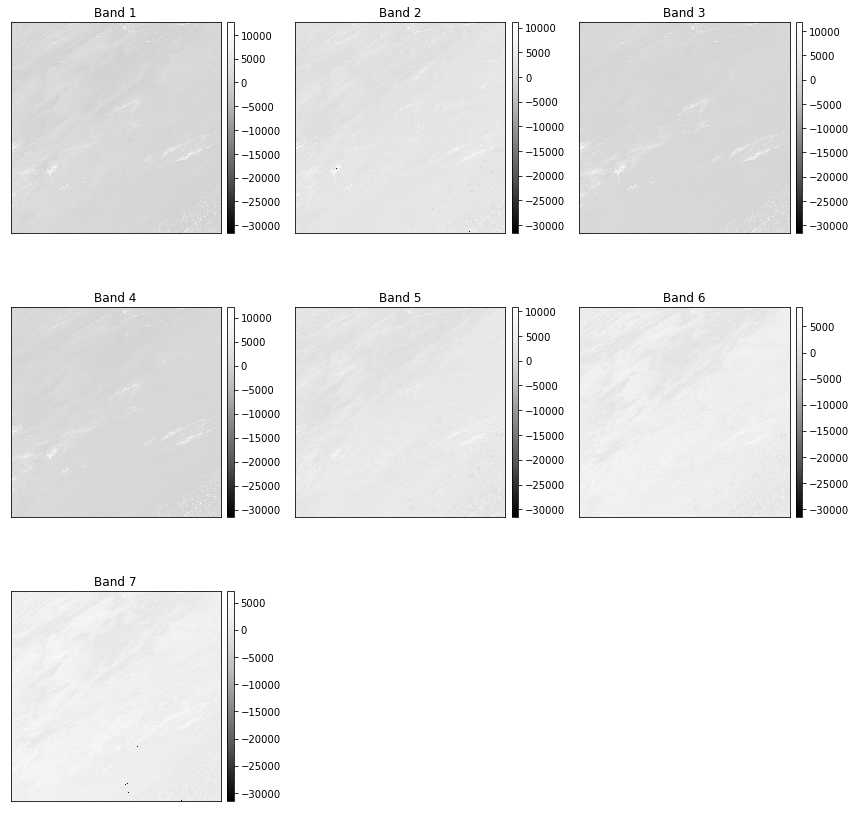

In [8]:
ep.plot_bands(pre_fire_modis,
              scale=False)
plt.show()

If you look at the <a href="{{ site.url }}/courses/earth-analytics-python/multispectral-remote-sensing-modis/modis-remote-sensing-data-in-python/"> table in the MODIS documentation or that is on the earthdatascience.org intermediate textbook,</a> you will see that the
range of value values for MODIS spans from **-100 to 16000**. 

There is also a fill or no data value **-28672** to consider. You can access this nodata
value using the rasterio metadata object.

In [ ]:
# View entire metadata object for a MODIS band
modis_meta

In [ ]:
# View just the nodata value
modis_meta["nodata"]

To address the valid range of values in your data, you can mask it using 
`numpy ma.masked_where()` which will mask specific values within a numpy
array. 

`ma.masked_where(pre_fire_modis == modis_meta["nodata"], pre_fire_modis)`

After masking the nodata values, the plot now shows a range of
values represented between **0-10,000** which is what you would expect.
The data also are also visibly less washed out!

In [10]:
# Mask no data values
pre_fire_modis = ma.masked_where(
    pre_fire_modis == modis_meta["nodata"], pre_fire_modis)

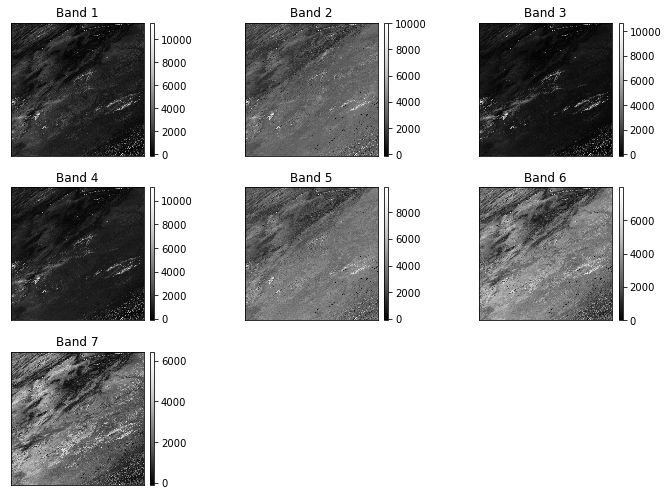

In [11]:
ep.plot_bands(pre_fire_modis,
              scale=False,
              figsize=(10, 7))
plt.show()

### RGB Image of MODIS Data Using EarthPy

Once you have your data cleaned up, you can plot an RGB image of your data 
to ensure that it looks correct!

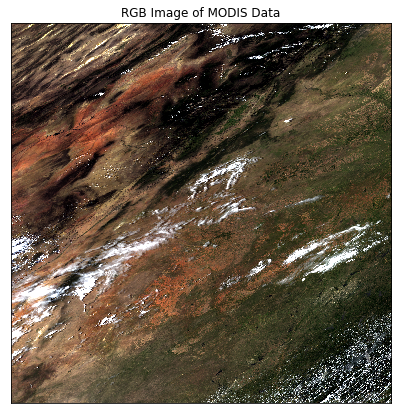

In [12]:
# Plot MODIS RGB
ep.plot_rgb(pre_fire_modis,
            rgb=[0, 3, 2],
            title='RGB Image of MODIS Data',
            stretch=True,
            figsize=(7, 7))

plt.show()

## Crop MODIS Data

Above you opened and plotted MODIS reflectance data. However the data 
cover a larger study area than you need. It is a good idea to crop it
the data to maximize processing efficiency.  

To begin you will want to check that th CRS of your crop layer (in this 
case the fire boundary layer that you have used in other lessons - 
`co_cold_springs_20160711_2200_dd83.shp`) is the same as your MODIS data. 

There are several different ways to check the CRS for your crop extent. 
You will need to get the CRS of the MODIS data prior to reprojecting the 
fire boundary. Below you do this by:

1. Creating a connection to the hdf4 file
2. Opening a connection to one single band 
3. Grabbing the CRS using the `src` object

Finally you use the CRS to check and reproject the fire boundary if it 
is not in the same CRS.

In [14]:
# Open fire boundary
fire_boundary_path = os.path.join("cold-springs-fire",
                                  "vector_layers",
                                  "fire-boundary-geomac",
                                  "co_cold_springs_20160711_2200_dd83.shp")
fire_boundary = gpd.read_file(fire_boundary_path)
# Check the CRS
fire_boundary.crs

{'init': 'epsg:4269'}

### Reproject the Clip Extent - (the Fire Boundary)

First reproject the fire boundary. Note that you do not need all of the 
print statments included below. They are included to help you see what is 
happening in the code!

In [15]:
# Check to see if you need to reproject the fire boundary
with rio.open(pre_fire_path) as dataset:
    for name in dataset.subdatasets:
        # get the first band
        if re.search("b01_1$", name):
            with rio.open(name) as subdataset:
                print("Fire Bound CRS:", fire_boundary.crs)
                print("MODIS CRS:", subdataset.crs)

                if not fire_boundary.crs == subdataset.crs:
                    print("I just reprojected the data!")
                    fire_bound_sin = fire_boundary.to_crs(subdataset.crs)

Fire Bound CRS: {'init': 'epsg:4269'}
MODIS CRS: PROJCS["unnamed",GEOGCS["Unknown datum based upon the custom spheroid",DATUM["Not_specified_based_on_custom_spheroid",SPHEROID["Custom spheroid",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]]],PROJECTION["Sinusoidal"],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1],AXIS["Easting",EAST],AXIS["Northing",NORTH]]
I just reprojected the data!


## Crop Your MODIS Data Using EarthPy

Once you have opened and reprojected your crop extent you can 
crop your MODIS raster data. Below you:

1. open up the fire boundary which you will use to crop your modis data. 
2. open and crop each band using earthpy's `crop_image()` function.
3. stack the data using `numpy.stack()`. 
4. address no data values using `numpy.ma.masked_where()`. 

Notice that the **nodata** value is pulled directly from the metadata 
object that you created  in the loop. 

`ma.masked_where(pre_fire_modis_crop == modis_meta["nodata"], pre_fire_modis_crop)`


In [16]:
# Open & stack the prefire reflectance data
all_bands = []

with rio.open(pre_fire_path) as dataset:
    for name in dataset.subdatasets:
        # Select only the bands (the reflectance data)
        if re.search("b0.\_1$", name):
            with rio.open(name) as subdataset:
                #modis_meta = subdataset.profile
                crop_band, crop_meta = es.crop_image(
                    subdataset, fire_bound_sin)
                # Append the band to a list
                all_bands.append(np.squeeze(crop_band))

# Stack the data and handle no data values
pre_fire_modis_crop = np.stack(all_bands)
pre_fire_modis_crop = ma.masked_where(
    pre_fire_modis_crop == modis_meta["nodata"], pre_fire_modis_crop)

# Optional - define a plotting extent
# You only need this code if you want to overlay the fire boundary on top of your reflectance data
extent_modis_pre = plotting_extent(
    pre_fire_modis_crop[0], crop_meta["transform"])

# View shape of the final cropped array
pre_fire_modis_crop.shape

(7, 3, 8)

### Plot Your Cropped MODIS Data

Once you have a stacked numpy array, you can process the data however you'd like.
Below, each band in the numpy array is plotted.

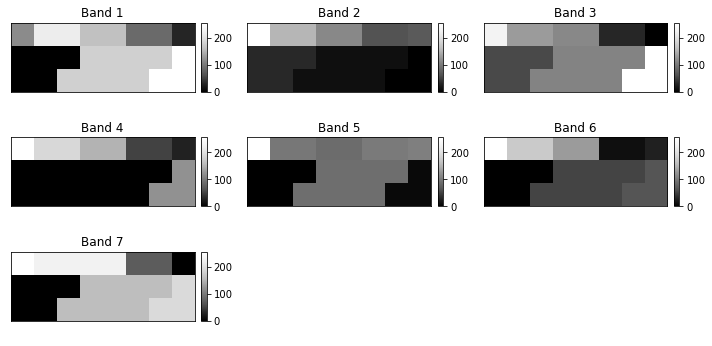

In [17]:
# Plot the data
ep.plot_bands(pre_fire_modis_crop,
              figsize=(10, 5))
plt.show()

## Basics of Creating Shapefiles with Geopandas

Below is a general overview so you can see how that works. 


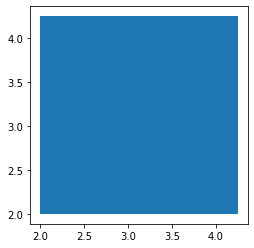

In [24]:
# You will need one of these: Polygon, Point of Linestring to create a poly, 
# point or line gdf.
from shapely.geometry import Polygon, Point, LineString

# Create a polygon
geom = Polygon([(2, 2), (2, 4.25), (4.25, 4.25), (4.25, 2), (2, 2)])
gdf = gpd.GeoDataFrame(geometry=[geom], crs="epsg:4326")

gdf.plot()

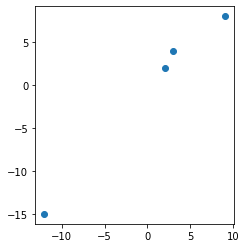

In [28]:
pts = np.array([[2, 2], [3, 4], [9, 8], [-12, -15]])
gdf_pt = gpd.GeoDataFrame(
    [Point(xy) for xy in pts], columns=["geometry"], crs="epsg:4326",
)
gdf_pt.plot()
plt.show()

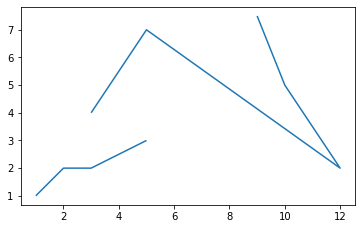

In [29]:
# Create lines
linea = LineString([(1, 1), (2, 2), (3, 2), (5, 3)])
lineb = LineString([(3, 4), (5, 7), (12, 2), (10, 5), (9, 7.5)])
gdf_line = gpd.GeoDataFrame([1, 2], geometry=[linea, lineb], crs="epsg:4326")

gdf_line.plot()

## Activity: Convert mm --> inches & Test Function Inputs

```python
    # Test for number
    try:
        inches = mm / 25.4 
        return inches
    except TypeError as te:
        print("Please check your input parameter type", te)
```

In [36]:
# Function that converts a value in mm to inches 
def mm_to_in(mm):
    """Convert input from millimeters to inches. 
    
    Parameters
    ----------
    mm : int or float
        Numeric value with units in millimeters.

    Returns
    ------
    inches : int or float
        Numeric value with units in inches.
    """
    
    try:
        inches = mm / 25.4 
        return inches
    except TypeError as te:
        print("Oops - I need a number to calculate inches", te)


In [39]:
mm_to_in("25")

Oops - I need a number to calculate inches unsupported operand type(s) for /: 'str' and 'float'


In [54]:
# Function review
### ['monday', 'tuesday', 'wednesday', 'thursday', 'friday']
precip_by_day_mm = {"monday": 5, "tuesday": 0,
                 "wednesday": 3, "thursday": 4, 
                 "friday": 0}

precip_by_day_in = {}

for aday in precip_by_day_mm.keys():
    print(aday)
    
    precip_by_day_in[aday] = mm_to_in(precip_by_day_mm[aday])
    
aday

monday
tuesday
wednesday
thursday
friday


'friday'

## Activity: Create a Function to Extract MODIS Bands From a H4 File

Below we will work together to pseudocode out the elements of the function 
`stack_modis_bands`
that you need to write for your homework assignment.


In [ ]:
#def stack_modis_bands(h4_path, crop_bound):
